In [1]:
# Graphing code (copy paste from repo)
from graphviz import Digraph
 
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random

# Overview of Differentiation

In [3]:
# Define a function
def f(x):
    return 3*x**2 - 4*x +5

f(3)

20

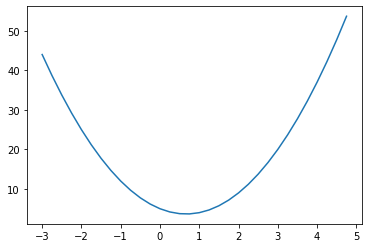

In [4]:
# Look at the function for a range of x
x = np.arange(-3, 5, 0.25)
plt.plot(x, f(x))

In [5]:
# Lowest y is around an x of 2/3
# Gradient at that point should be 0.
# Using fudamental theorem of calculus to numerically check.

h = 0.000001  # Define a small step size
x = 0.66 # The x we assume to be a grad of 0. 

(f(x+h) - f(x))/h  # Fundamental theory of calculus

-0.039997000378377834

In [6]:
# Looking at another way of calculating the derivative
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10

# The functions
d1 = a*b+c
a+=h
d2 = a*b+c


print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


# Implementing Micro-Grad

In [7]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data  # Variable to store the value
        self.grad = 0.0  # Variable to store the LOCAL gradient
        self._backward = lambda: None  # Placeholder for the backprop function
        self._prev = set(_children)  # Variable to hold the set of (imediate) children 
        self._op = _op  # Variable to store the operation that created the variable
        self.label = label  # Variable to store the variable label
        
    def __repr__(self):  
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self+other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self*other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), 'only supporting int or float'
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += out.grad * (other*self.data**(other-1))
        
        out._backward = _backward 
        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
            
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad +=  out.grad * out.data
        out._backward = _backward
        
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1-t**2) * out.grad
            
        out._backward = _backward
        return out
    
    def backward(self):
        
        # Topological sort
        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
                
        build_topo(self)
        self.grad=1.0
        for node in reversed(topo):
            node._backward()

In [8]:
# Test Space 
a = Value(2)
b = Value(4)
a-b

Value(data=-2)

# Backpropagation on a Neuron

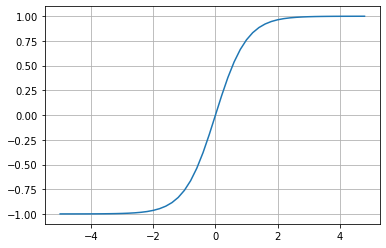

In [9]:
# The tanh activation function
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

In [10]:
# Defining a neuron
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

# neuron
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label ='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label='o'

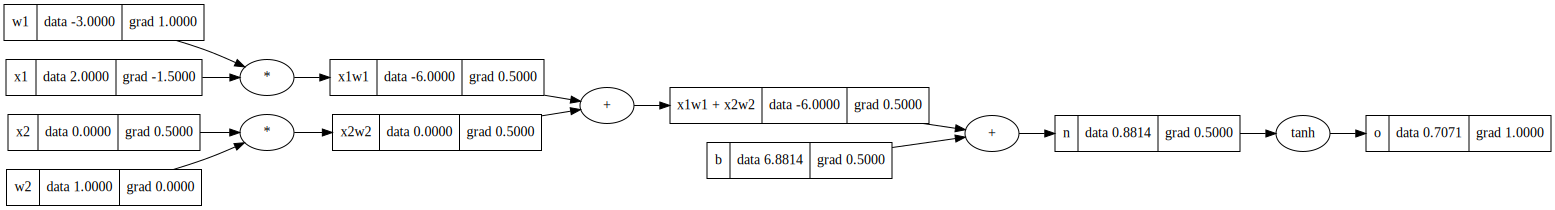

In [11]:
o.backward()
draw_dot(o)

In [12]:
# Defining a neuron not using tanh function
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

# neuron
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label ='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# ---
e = (2*n).exp()
o = (e-1)/(e+1)
# ---
o.label = 'o'
o.backward()

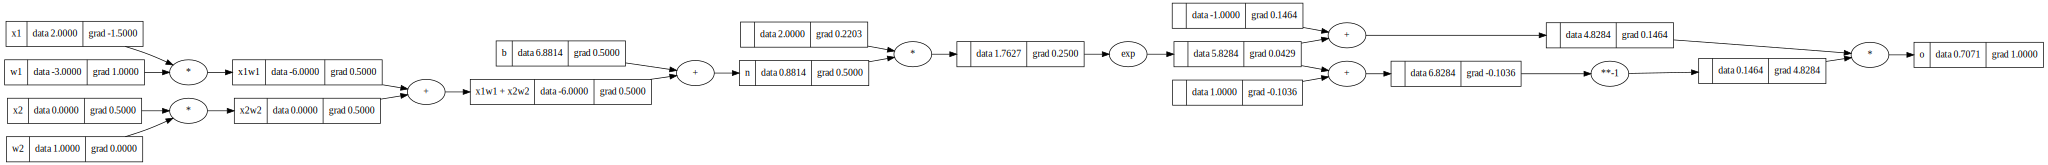

In [13]:
draw_dot(o)

# Building Neural Network Module

In [14]:
class neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        return act.tanh()
    
    def parameters(self):
        return self.w + [self.b]
    
class layer:
    
    def __init__(self, nin, nout):
        self.neurons = [neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
            
class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        
    
x = [2.0, 3.0, -1] # Three inputs
n = MLP(3, [4, 4, 1]) # Three inputs with two layers of 4 and 1 output
n(x)

Value(data=-0.548479575995325)

In [15]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5], 
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]

In [16]:
for k in range(200):
    
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))
    
    # backward pass
    for p in n.parameters(): # Need to reset the grad to 0 every backward pass (due to the +=)
        p.grad = 0.0
    loss.backward()
    
    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad # Taking a negative stepsize as a way to walk down the gradient (we are changing x values)
        
    print(k, loss.data)

0 4.837984227836847
1 2.5030798673312917
2 1.2210242594200582
3 0.6255355663352891
4 0.3432473330696506
5 0.22978155706782824
6 0.1701996184254388
7 0.13353426025160658
8 0.10909744256019854
9 0.09180720900212261
10 0.07900285049173847
11 0.06917741976488768
12 0.061421222901524075
13 0.055155813482912375
14 0.04999728047953028
15 0.04568155218085626
16 0.04202141751648028
17 0.038880683671761576
18 0.03615803870124194
19 0.03377663897248527
20 0.03167719556734877
21 0.029813266845836545
22 0.028147980850387597
23 0.026651707371680107
24 0.025300374723653256
25 0.024074232913771875
26 0.022956931455535044
27 0.021934822577975202
28 0.02099642830403791
29 0.02013202828884129
30 0.0193333377635614
31 0.018593253487987082
32 0.017905651581487315
33 0.017265225319556342
34 0.016667354002001818
35 0.016107996185358353
36 0.015583602173209855
37 0.015091041842591342
38 0.014627544769368957
39 0.014190650282302571
40 0.013778165582328375
41 0.013388130451925549
42 0.013018787379206254
43 0.01

331 0.0013266097190225592
332 0.0013223262238374967
333 0.0013180696361141176
334 0.0013138397056237812
335 0.0013096361852137839
336 0.0013054588307605279
337 0.0013013074011232989
338 0.0012971816580990665
339 0.0012930813663780479
340 0.0012890062935000876
341 0.0012849562098117113
342 0.0012809308884241788
343 0.0012769301051720498
344 0.0012729536385726267
345 0.0012690012697860694
346 0.0012650727825762726
347 0.0012611679632723227
348 0.001257286600730796
349 0.001253428486298537
350 0.001249593413776265
351 0.001245781179382652
352 0.00124199158171919
353 0.0012382244217355343
354 0.0012344795026954982
355 0.001230756630143686
356 0.001227055611872601
357 0.001223376257890403
358 0.0012197183803891584
359 0.0012160817937136954
360 0.0012124663143309434
361 0.0012088717607997561
362 0.0012052979537414033
363 0.0012017447158103182
364 0.0011982118716656193
365 0.0011946992479428262
366 0.001191206673226254
367 0.001187733978021842
368 0.0011842809947302966
369 0.00118084755762089

670 0.0006258870100995702
671 0.0006248991529377659
672 0.0006239143446316362
673 0.0006229325712087257
674 0.0006219538187814074
675 0.000620978073546251
676 0.0006200053217834074
677 0.0006190355498559366
678 0.0006180687442092325
679 0.0006171048913703852
680 0.0006161439779475441
681 0.0006151859906293541
682 0.0006142309161843174
683 0.0006132787414602276
684 0.0006123294533835524
685 0.0006113830389588503
686 0.0006104394852682193
687 0.0006094987794706919
688 0.0006085609088016642
689 0.0006076258605723513
690 0.0006066936221692145
691 0.0006057641810533977
692 0.0006048375247602059
693 0.0006039136408985269
694 0.0006029925171502988
695 0.0006020741412699905
696 0.000601158501084055
697 0.0006002455844904087
698 0.0005993353794579097
699 0.0005984278740258322
700 0.0005975230563033763
701 0.0005966209144691067
702 0.0005957214367705309
703 0.0005948246115235219
704 0.0005939304271118664
705 0.0005930388719867611
706 0.0005921499346663244
707 0.0005912636037351146
708 0.00059037

1011 0.0004053340759758939
1012 0.000404912318123249
1013 0.00040449142042989987
1014 0.0004040713802876697
1015 0.0004036521950988491
1016 0.0004032338622761757
1017 0.00040281637924278373
1018 0.00040239974343211904
1019 0.00040198395228791526
1020 0.000401569003264131
1021 0.0004011548938249039
1022 0.0004007416214445132
1023 0.0004003291836072877
1024 0.00039991757780760587
1025 0.00039950680154980526
1026 0.0003990968523481656
1027 0.0003986877277268458
1028 0.00039827942521982005
1029 0.0003978719423708482
1030 0.00039746527673344156
1031 0.0003970594258707453
1032 0.0003966543873556152
1033 0.00039625015877043843
1034 0.0003958467377071519
1035 0.00039544412176721773
1036 0.00039504230856152086
1037 0.00039464129571035393
1038 0.0003942410808433627
1039 0.0003938416615995086
1040 0.00039344303562701907
1041 0.0003930452005833357
1042 0.00039264815413508127
1043 0.00039225189395799805
1044 0.000391856417736927
1045 0.00039146172316573835
1046 0.0003910678079472988
1047 0.00039067

1311 0.0003084403296701527
1312 0.0003081935760305815
1313 0.0003079472098170027
1314 0.0003077012301244118
1315 0.00030745563605061185
1316 0.00030721042669619577
1317 0.00030696560116453837
1318 0.00030672115856178754
1319 0.0003064770979968632
1320 0.0003062334185814248
1321 0.00030599011942988446
1322 0.0003057471996593575
1323 0.0003055046583897178
1324 0.00030526249474351183
1325 0.00030502070784601675
1326 0.0003047792968251768
1327 0.0003045382608116141
1328 0.0003042975989386418
1329 0.0003040573103421972
1330 0.000303817394160891
1331 0.0003035778495359648
1332 0.00030333867561128106
1333 0.00030309987153332287
1334 0.0003028614364511895
1335 0.00030262336951656233
1336 0.00030238566988372316
1337 0.00030214833670953517
1338 0.00030191136915340595
1339 0.0003016747663773258
1340 0.0003014385275458226
1341 0.0003012026518259666
1342 0.0003009671383873509
1343 0.0003007319864021037
1344 0.0003004971950448475
1345 0.0003002627634927069
1346 0.0003000286909253116
1347 0.000299794

1613 0.00024819082582352937
1614 0.0002480298101081676
1615 0.0002478689996033112
1616 0.000247708393919678
1617 0.00024754799266894816
1618 0.0002473877954637827
1619 0.0002472278019178198
1620 0.0002470680116456773
1621 0.0002469084242629195
1622 0.0002467490393860943
1623 0.0002465898566327081
1624 0.00024643087562121747
1625 0.00024627209597104184
1626 0.00024611351730255686
1627 0.0002459551392370824
1628 0.0002457969613968807
1629 0.00024563898340517615
1630 0.0002454812048861112
1631 0.00024532362546477945
1632 0.00024516624476721594
1633 0.0002450090624203654
1634 0.00024485207805212953
1635 0.0002446952912913199
1636 0.000244538701767671
1637 0.0002443823091118464
1638 0.0002442261129554259
1639 0.00024407011293089276
1640 0.00024391430867166163
1641 0.00024375869981204892
1642 0.00024360328598726697
1643 0.0002434480668334447
1644 0.0002432930419876073
1645 0.00024313821108768415
1646 0.0002429835737724868
1647 0.00024282912968173504
1648 0.00024267487845602555
1649 0.0002425

1914 0.00020751549361880856
1915 0.00020740223852763198
1916 0.0002072891049529885
1917 0.00020717609270073104
1918 0.0002070632015771404
1919 0.00020695043138889202
1920 0.0002068377819430726
1921 0.0002067252530471893
1922 0.00020661284450914242
1923 0.0002065005561372495
1924 0.00020638838774022963
1925 0.00020627633912720356
1926 0.00020616441010769048
1927 0.00020605260049162986
1928 0.0002059409100893448
1929 0.0002058293387115627
1930 0.00020571788616941873
1931 0.00020560655227442692
1932 0.00020549533683851485
1933 0.00020538423967401308
1934 0.0002052732605936147
1935 0.0002051623994104407
1936 0.0002050516559379859
1937 0.00020494102999013975
1938 0.00020483052138118313
1939 0.00020472012992579653
1940 0.000204609855439035
1941 0.00020449969773633965
1942 0.00020438965663355392
1943 0.00020427973194689733
1944 0.0002041699234929667
1945 0.00020406023108875829
1946 0.00020395065455163725
1947 0.00020384119369935936
1948 0.00020373184835005494
1949 0.0002036226183222332
1950 0

In [17]:
ypred

[Value(data=0.9945288336024839),
 Value(data=-0.9923658700648559),
 Value(data=-0.9940048284544633),
 Value(data=0.9913890438639212)]